# Transformer (Attention Is All You Need) 구현하기 


# 0. Settings

In [1]:
import sentencepiece as spm
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 1. Vocab
- sentencepiece로 미리 생성해둔 vocab을 이용해 입력 텍스트를 tensor로 변경

In [2]:
# vocab loading
vocab_file = "./kowiki_vocab_data/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

# input texts
lines = [
    "겨울은 추워요.",
    "감기 조심하세요."
]

# text to tensor
inputs = []
for line in lines:
    pieces = vocab.encode_as_pieces(line)
    ids = vocab.encode_as_ids(line)
    inputs.append(torch.tensor(ids))
    print(pieces)
    
# 입력 길이가 다르므로 입력 최대 길이에 맞춰 padding(0)을 추가
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first = True, padding_value = 0)
# shape and value
inputs.size(), inputs

['▁겨울', '은', '▁추', '워', '요', '.']
['▁감', '기', '▁조', '심', '하', '세', '요', '.']


(torch.Size([2, 8]),
 tensor([[3159, 3533,  200, 3883, 3688, 3519,    0,    0],
         [ 206, 3534,   53, 3759, 3525, 3613, 3688, 3519]]))

# 2. Embedding
- Transformer의 임베딩은 아래의 두 가지 방법을 합해서 사용
1. Input embedding
2. Position Embedding

## 2-1. Input Embedding
- 임베딩은 입력 토큰을 벡터 형태로 변환함
### 1) 인풋에 대한 임베딩 값 input_embs구하기
- inputs(2,8)에 대한 임베딩 값 input_embs(2,8,128) shape을 가짐

In [32]:
n_vocab = len(vocab) # vocab count
d_hidn = 128 # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn) # embedding object

input_embs = nn_emb(inputs) # input embedding
input_embs.size()

torch.Size([2, 8, 128])

## 2-2. Position Embedding
1. 각 포지션 별로 angle 값 구하기
2. 구해진 angle 중 짝수 idx 값에 대한 sin값 구하기
3. 구해진 angle 중 홀수 idx 값에 대한 cos값 구하기

**position encoding function**
- [계산 참고](https://skyjwoo.tistory.com/entry/positional-encoding%EC%9D%B4%EB%9E%80-%EB%AC%B4%EC%97%87%EC%9D%B8%EA%B0%80)

In [4]:
"""sinusoid position embedding"""
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

(64, 128)


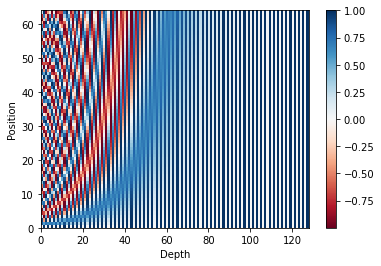

In [5]:
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)
print(pos_encoding.shape) # 크기 출력
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### position embedding 값을 구하는 절차
1. 위에서 구해진 position encoding값을 이용해 position embedding 생성
    - 학습되는 값이 아니므로 freeze 옵션을 True로 설정
2. 입력 inputs과 동일한 크기를 갖는 positions 값 구하기
3. input값 중 pad(0)값 찾기
4. positions 값 중 pad 부분은 0으로 변경
5. positions 값에 해당하는 embedding 값 구하기

In [22]:
# check the line 5
tmp = torch.arange(8)
tmp, tmp.expand(2,8), tmp.expand(2,8).contiguous() + 1

(tensor([0, 1, 2, 3, 4, 5, 6, 7]),
 tensor([[0, 1, 2, 3, 4, 5, 6, 7],
         [0, 1, 2, 3, 4, 5, 6, 7]]),
 tensor([[1, 2, 3, 4, 5, 6, 7, 8],
         [1, 2, 3, 4, 5, 6, 7, 8]]))

In [24]:
inputs.eq(0)

tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False]])

In [26]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze = True)

# torch.arange(end = 8, device = cpu, dtype = torch.int64)
positions = torch.arange(inputs.size(1), device = inputs.device, 
                         dtype=inputs.dtype).expand(inputs.size(0),
                                                    inputs.size(1)).contiguous() + 1
# inputs.eq(0) : 값이 0일 경우 True 반환
pos_mask = inputs.eq(0)
positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # Position Embedding

inputs, positions, pos_embs.size()

(tensor([[3159, 3533,  200, 3883, 3688, 3519,    0,    0],
         [ 206, 3534,   53, 3759, 3525, 3613, 3688, 3519]]),
 tensor([[1, 2, 3, 4, 5, 6, 0, 0],
         [1, 2, 3, 4, 5, 6, 7, 8]]),
 torch.Size([2, 8, 128]))

- input_embs, pos_embs는 (2,8,128)로 동일함
- 두 값을 더한게 transformer에 입력할 Input값이 됨

In [34]:
inputs_sums = input_embs + pos_embs

# 3. Scaled Dot Product Attention
- [상세 계산 내용 참고](https://simpling.tistory.com/3)
1. MatMul : Q,K
2. Scale
3. Mask(opt.)
4. SoftMax
5. MatMul : V

### 입력값 : Query, Key, Value 그리고 Attention Mask로 구성 됨
- 입력값 중 K,V는 같은 값이어야 함
    - Q,K,V가 모두 동일할 경우 self attention이라 함

In [40]:
Q = K = V = inputs_sums # self attention

# inputs.eq(0) : pad(0) 부분만 True
# .unsqueeze(1) : size[2,8] -> 두 번째 차원에 1인 차원 추가 -> size[2, 1, 8]
# .expand(2,8,8)
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
attn_mask.size(), attn_mask[0]

(torch.Size([2, 8, 8]),
 tensor([[False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True]]))

## 3-1. MatMul : Q, K
### 각 단어 상호간에 가중치를 표현하는 테이블 생성
- Query와 Key의 행렬 계산은 Q * K-transpose 수행
    - 이는 내적 연산과 같은 과정으로 각 단어에 대한 attention score를 구할 수 있음 
- 내적 연산 결과는 -1~1사이의 값을 가짐
    - 어떤 쿼리와 키가 중요한 역할을 하고 있다면 attention block은 이들 사이의 내적 값을 키우는 방식으로 학습
    - 내적 값이 커지면 해당 쿼리와 키가 벡터 공간상 가까이 있을 가능성이 큼

In [60]:
scores = torch.matmul(Q, K.transpose(-1,-2))
scores.size(), scores[0]

(torch.Size([2, 8, 8]),
 tensor([[161.6671,  66.4975,  48.8140,  55.0819,  56.3461,  67.2860,  48.7868,
           48.7868],
         [ 66.4975, 200.3137,  63.9023,  55.6129,  74.1046,  51.0003,  53.0092,
           53.0092],
         [ 48.8140,  63.9023, 192.2759,  54.8248,  65.1568,  50.1685,  71.6417,
           71.6417],
         [ 55.0819,  55.6129,  54.8248, 244.8802,  80.1461,  75.4440,  41.2612,
           41.2612],
         [ 56.3461,  74.1046,  65.1568,  80.1461, 197.4663,  46.6134,  67.9760,
           67.9760],
         [ 67.2860,  51.0003,  50.1685,  75.4440,  46.6134, 177.6136,  53.1463,
           53.1463],
         [ 48.7868,  53.0092,  71.6417,  41.2612,  67.9760,  53.1463, 189.8435,
          189.8435],
         [ 48.7868,  53.0092,  71.6417,  41.2612,  67.9760,  53.1463, 189.8435,
          189.8435]], grad_fn=<SelectBackward>))

## 3-2. Scale
- 행렬 연산(내적) 후 벡터의 차원이 커지면 학습이 잘 안될 수 있으므로 스케일링 과정 거침
    - k-dimension에 루트를 취한 값으로 나누어 줌
- 가중치 편차가 scale 전과 비교하여 줄어듬을 확인할 수 있음

In [61]:
d_head = 64
scores = scores.mul_(1/d_head ** 0.5)
scores.size(), scores[0]

(torch.Size([2, 8, 8]),
 tensor([[20.2084,  8.3122,  6.1018,  6.8852,  7.0433,  8.4108,  6.0983,  6.0983],
         [ 8.3122, 25.0392,  7.9878,  6.9516,  9.2631,  6.3750,  6.6261,  6.6261],
         [ 6.1018,  7.9878, 24.0345,  6.8531,  8.1446,  6.2711,  8.9552,  8.9552],
         [ 6.8852,  6.9516,  6.8531, 30.6100, 10.0183,  9.4305,  5.1576,  5.1576],
         [ 7.0433,  9.2631,  8.1446, 10.0183, 24.6833,  5.8267,  8.4970,  8.4970],
         [ 8.4108,  6.3750,  6.2711,  9.4305,  5.8267, 22.2017,  6.6433,  6.6433],
         [ 6.0983,  6.6261,  8.9552,  5.1576,  8.4970,  6.6433, 23.7304, 23.7304],
         [ 6.0983,  6.6261,  8.9552,  5.1576,  8.4970,  6.6433, 23.7304, 23.7304]],
        grad_fn=<SelectBackward>))

## 3-3. Mask (Opt.)
- 자신보다 뒤에 있는 단어를 참고하지 않게 해주기 위해 mask해줌 
    - 전체 문장을 한 번에 행렬 형태로 입력하는 구조임
    - 따라서 mask를 하지않을 경우 자신보다 뒤에 있는 단어를 참고해서 단어를 예측하는 상황이 생길 수 있음
- Qeury 단어 뒤에 나오는 Key 단어들에 대해서 masking 진행

In [64]:
scores.masked_fill_(attn_mask, -1e9)
scores.size(), scores[0]

(torch.Size([2, 8, 8]),
 tensor([[ 2.0208e+01,  8.3122e+00,  6.1018e+00,  6.8852e+00,  7.0433e+00,
           8.4108e+00, -1.0000e+09, -1.0000e+09],
         [ 8.3122e+00,  2.5039e+01,  7.9878e+00,  6.9516e+00,  9.2631e+00,
           6.3750e+00, -1.0000e+09, -1.0000e+09],
         [ 6.1018e+00,  7.9878e+00,  2.4034e+01,  6.8531e+00,  8.1446e+00,
           6.2711e+00, -1.0000e+09, -1.0000e+09],
         [ 6.8852e+00,  6.9516e+00,  6.8531e+00,  3.0610e+01,  1.0018e+01,
           9.4305e+00, -1.0000e+09, -1.0000e+09],
         [ 7.0433e+00,  9.2631e+00,  8.1446e+00,  1.0018e+01,  2.4683e+01,
           5.8267e+00, -1.0000e+09, -1.0000e+09],
         [ 8.4108e+00,  6.3750e+00,  6.2711e+00,  9.4305e+00,  5.8267e+00,
           2.2202e+01, -1.0000e+09, -1.0000e+09],
         [ 6.0983e+00,  6.6261e+00,  8.9552e+00,  5.1576e+00,  8.4970e+00,
           6.6433e+00, -1.0000e+09, -1.0000e+09],
         [ 6.0983e+00,  6.6261e+00,  8.9552e+00,  5.1576e+00,  8.4970e+00,
           6.6433e+00, -1.

## 3-4. Softmax
- 0~1사이의 확률값으로 변환

In [65]:
attn_prob = nn.Softmax(dim=-1)(scores)
attn_prob.size(), attn_prob[0]

(torch.Size([2, 8, 8]),
 tensor([[9.9998e-01, 6.8161e-06, 7.4741e-07, 1.6362e-06, 1.9163e-06, 7.5222e-06,
          0.0000e+00, 0.0000e+00],
         [5.4393e-08, 1.0000e+00, 3.9324e-08, 1.3953e-08, 1.4077e-07, 7.8388e-09,
          0.0000e+00, 0.0000e+00],
         [1.6290e-08, 1.0740e-07, 1.0000e+00, 3.4531e-08, 1.2563e-07, 1.9295e-08,
          0.0000e+00, 0.0000e+00],
         [4.9711e-11, 5.3122e-11, 4.8139e-11, 1.0000e+00, 1.1405e-09, 6.3365e-10,
          0.0000e+00, 0.0000e+00],
         [2.1829e-08, 2.0095e-07, 6.5665e-08, 4.2762e-07, 1.0000e+00, 6.4666e-09,
          0.0000e+00, 0.0000e+00],
         [1.0249e-06, 1.3383e-07, 1.2062e-07, 2.8414e-06, 7.7342e-08, 1.0000e+00,
          0.0000e+00, 0.0000e+00],
         [3.0097e-02, 5.1021e-02, 5.2390e-01, 1.1749e-02, 3.3132e-01, 5.1904e-02,
          0.0000e+00, 0.0000e+00],
         [3.0097e-02, 5.1021e-02, 5.2390e-01, 1.1749e-02, 3.3132e-01, 5.1904e-02,
          0.0000e+00, 0.0000e+00]], grad_fn=<SelectBackward>))

## 3-5. MatMul atten_prov, V
- value와 행렬곱을 해줘서 각 context vector 구하기

In [66]:
context = torch.matmul(attn_prob, V)
context.size()

torch.Size([2, 8, 128])

### Scaled Dot Procudt Attention Class

In [ ]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob